In [1]:
#importing the requests library
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import yfinance as yf #using the yahoo finance library 
from yahoofinancials import YahooFinancials
import warnings
warnings.filterwarnings('ignore')

Getting stock data using the open source yahoo finance library. More information can be found [here](https://pypi.org/project/yfinance/)

In [29]:
#function to get stock data of a company

def stock_info(ticker):
    #define dates for 5 years
    start_date = '2017-01-01'
    end_date = '2022-12-31'
    df = yf.download(ticker,start=start_date,end=end_date)
    #plot the stock price over the years
    fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(df['Adj Close']);
    ax.set_title(f'Stock price of {ticker} from 2017 to 2022');
    plt.show();
    
    return ax

In [3]:
#function to calculate stock return

def stock_return(ticker):
    start_date = '2017-01-01'
    end_date = '2022-12-31'
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_return['pct_change'] = df_return['Adj Close'].pct_change() # use pct change to calculate the diff 
    df_return.drop(df_return.index[0],inplace=True) # drop the Nan value from the first row
    
    #plot the returns over 5 years
    fig,ax = plt.subplots(figsize=(8,8))
    ax.plot(df_return['pct_change'])
    ax.set_title('Stock Return Pct from 2017 to 2022:' +' ' + ticker)
    plt.show();
    
    return fig,ax
      

In [4]:
#function to calculate beta value of stock

def calculate_beta(ticker):
    
    #get data for ticker and SPY whih serves as the market index
    symbols = [ticker,'SPY']
    data = yf.download(symbols, start = '2019-01-01',end = '2022-12-31')['Adj Close']
    price_change = data.pct_change()
    price_change.drop(price_change.index[0],inplace=True)
    
    #reshape for linear regression
    X = np.array(price_change[ticker]).reshape((-1,1))
    y = np.array(price_change['SPY'])

    #create splits
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    #predictions
    y_preds = lr.predict(X_test)

    #plot 
    fig,ax = plt.subplots(figsize=(8,8));
    ax.plot(X_test,y_preds,linestyle=':',color='orange')
    ax.scatter(y_test,y_preds,alpha=0.5)
    ax.set_title(f' Beta value = {lr.coef_}')
    ax.set_xlabel('Market Index:SPY')
    ax.set_ylabel(f'{ticker} value')
    plt.show();
    
    return fig,ax

In [5]:
#function to get historical PE ratios

def get_pe_ratio(ticker):
    
    #get financial statement of ticker using yahoofinancials
    financials = YahooFinancials(ticker)
    statement = financials.get_financial_stmts('annual', 'income', reformat=True)    
    
    #create a dict of the income statement alone
    dicts ={}
    for i in statement['incomeStatementHistory'][ticker]:
        dicts.update(i)
    
    #create a dataframe for easy use
    df = pd.DataFrame(dicts)
    df = df.T
    df['dilutedAverageShares'].fillna(df['dilutedAverageShares'].median(),inplace=True)
    
    #calculate pe ratio
    eps = df['netIncomeContinuousOperations']/df['dilutedAverageShares'] #calc earnings per share
    eps_df = pd.DataFrame(eps,index=df.index,columns=['EPS'])
    eps_df['PE ratio'] = financials.get_current_price()/eps_df['EPS']#get current price and calc pe ratio
    
    #plot result
    fig,ax=plt.subplots(figsize=(8,8));
    ax.plot(eps_df['PE ratio'],marker = '*', markerfacecolor = 'black')
    ax.set_title(f'Historical PE ratio: {ticker}')
    ax.set_ylabel('PE ratio')
    plt.show()
    
    return fig,ax

In [6]:
#function to get historical dividend data

def get_dividend(ticker):
    
    #get dividend data
    financials = YahooFinancials(ticker)
    div = financials.get_daily_dividend_data('2017-01-01','2022-12-31')
    
    #check if the company pays dividends
    if div[ticker] == None:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.annotate(f'Sorry, {ticker} does not offer dividends',xy=(0.3,0.5),fontsize=20);
        ax.axis('off')
        return fig,ax
    
    else:#if company does pay dividends,then convert to a df and create a plot
        df = pd.DataFrame(div[ticker])
        df.drop('date',axis=1,inplace=True)
        df.rename(columns={'formatted_date':'date'},inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        fig,ax=plt.subplots(figsize=(8,8))
        ax.plot(df['amount'],marker = '*', markerfacecolor = 'black');
        ax.set_title(f'Dividend rate: {ticker}')
        
    return fig,ax

In [7]:
def summary_info(ticker):
    return stock_info(ticker), stock_return(ticker), get_pe_ratio(ticker),get_dividend(ticker)

[*********************100%***********************]  1 of 1 completed


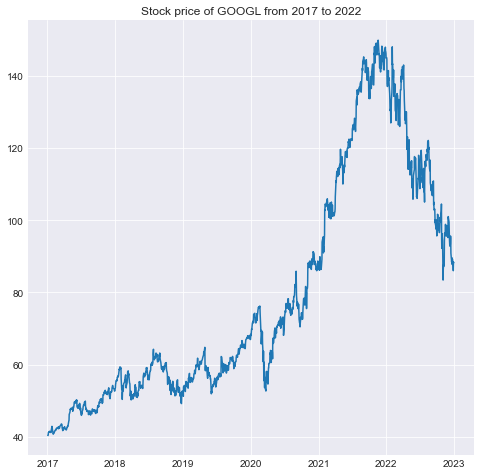

[*********************100%***********************]  1 of 1 completed


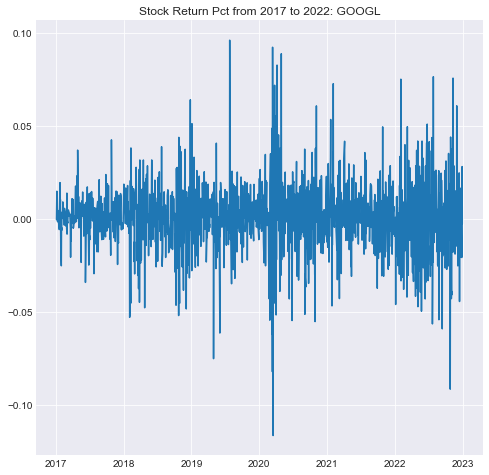

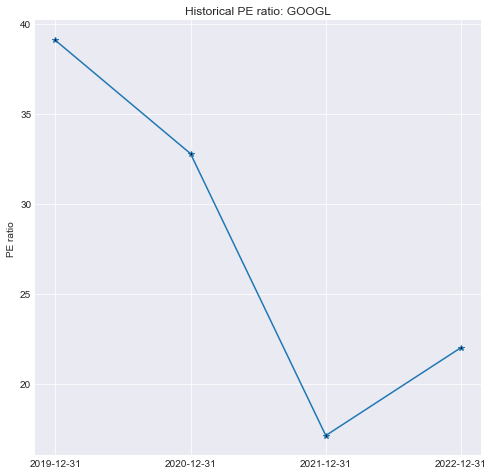

(<AxesSubplot:title={'center':'Stock price of GOOGL from 2017 to 2022'}>,
 (<Figure size 576x576 with 1 Axes>,
  <AxesSubplot:title={'center':'Stock Return Pct from 2017 to 2022: GOOGL'}>),
 (<Figure size 576x576 with 1 Axes>,
  <AxesSubplot:title={'center':'Historical PE ratio: GOOGL'}, ylabel='PE ratio'>),
 (<Figure size 360x360 with 1 Axes>, <AxesSubplot:>))

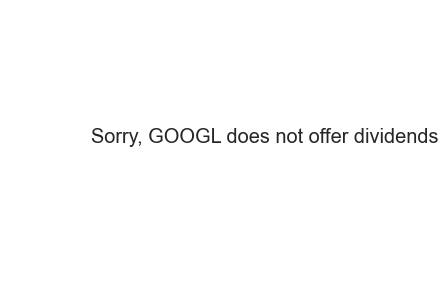

In [32]:
summary_info('GOOGL')